In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import random
from utils import read_qrels

import numpy as np
from sklearn.isotonic import IsotonicRegression as IR
from sklearn.linear_model import LogisticRegression as LR
from calibration_utils import (
    eval_model_or_param_on_samples,
    Temperature_Scaling,
    format_multigrade,
    convert_samples_to_flat_format
)
# from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, mean_squared_error, ndcg_score

# import torch
# import torch.nn.functional as F
# from torch.autograd import Variable
# import matplotlib.pyplot as plt

In [3]:
# model_name = "monobert-large-msmarco"
model_name = "monot5-base-msmarco"
# model_name = "monot5-base-msmarco-10k"

# model_name = "Llama-2-13B-chat-AWQ-tf-zero"

binarize_labels = False
max_grade = 3

# binarize_labels = True
# max_grade = 1

# model_name = "rankllama-v1-7b-lora-passage"
# max_grade = 1

reverse_logit = False
downsample_negative = None
skip_query_level_ece = False

if binarize_labels and max_grade != 1:
    assert False

if "AWQ" in model_name and not reverse_logit:
    assert False  # in AWQ models, first logits maps to YES

folder_dir = f"calibration-exp/scores/{model_name}"
scored_qd = {}
for dct in [
    pickle.load(open(f"{folder_dir}/marcov1-results.trec.pkl", "rb")),
    pickle.load(open(f"{folder_dir}/marcov2-results.trec.pkl", "rb"))
]:
    scored_qd.update(dct)

qrels_all = {}
# for qrels in [read_qrels("msmarco-passage/dev/small")]: # eval has no relevance judgement!
#     qrels_all.update(qrels)
for qrels in [
    read_qrels("msmarco-passage/trec-dl-2019/judged"),
    read_qrels("msmarco-passage/trec-dl-2020/judged"),
    read_qrels("msmarco-passage-v2/trec-dl-2021/judged"),
    read_qrels("msmarco-passage-v2/trec-dl-2022/judged"),
]:
    qrels_all.update(qrels)

print(len(qrels_all))

dev_queries = [x for x in read_qrels("msmarco-passage/trec-dl-2019/judged") if x in scored_qd]
test_queries = [x for x in qrels_all if x not in set(dev_queries) and x in scored_qd]
print(len(dev_queries), len(test_queries))

226
43 174


In [4]:
# model_name = "it5-base-istella-title_url_text"
# max_grade = 4
# reverse_logit = True
# # downsample_negative = None
# downsample_negative = 0.1
# skip_query_level_ece = True

# folder_dir = f"calibration-exp/scores/{model_name}"
# scored_qd = pickle.load(open(f"{folder_dir}/istella22-test-results.pkl", "rb"))

# qrels_all = read_qrels("istella22/test")

# unique_queries = [x for x in list(scored_qd.keys()) if x in qrels_all]
# random.seed(611)
# dev_queries = random.sample(unique_queries, int(len(unique_queries) * 0.25))
# test_queries = [x for x in unique_queries if x not in set(dev_queries)]
# print(len(dev_queries), len(test_queries))

In [5]:
dev_samples = format_multigrade(
    queries=dev_queries,
    qrels=qrels_all,
    scored_qd=scored_qd,
    scale_score_to_max=True,
    binarize_labels=binarize_labels,
    max_grade=max_grade,
    reverse_logit=reverse_logit,
    downsample_negative=downsample_negative
)

test_samples = format_multigrade(
    queries=test_queries,
    qrels=qrels_all,
    scored_qd=scored_qd,
    scale_score_to_max=True,
    binarize_labels=binarize_labels,
    max_grade=max_grade,
    reverse_logit=reverse_logit,
    downsample_negative=downsample_negative
)

## platt's scaling

[5158, 1601, 1804, 697]
DEV --
	BEFORE 	 AFTER
nDCG:	0.895	0.895
MSE:	1.227	0.801
ECE_y:	0.579	0.466
ECE:	0.621	0.042


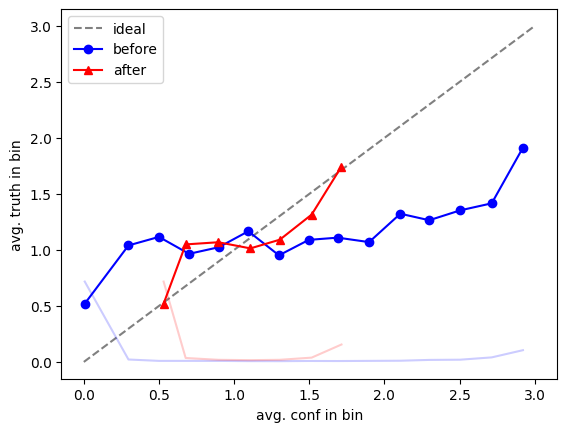



TEST --
	BEFORE 	 AFTER
nDCG:	0.856	0.856
MSE:	1.375	0.747
ECE_y:	0.704	0.462
ECE:	0.674	0.215


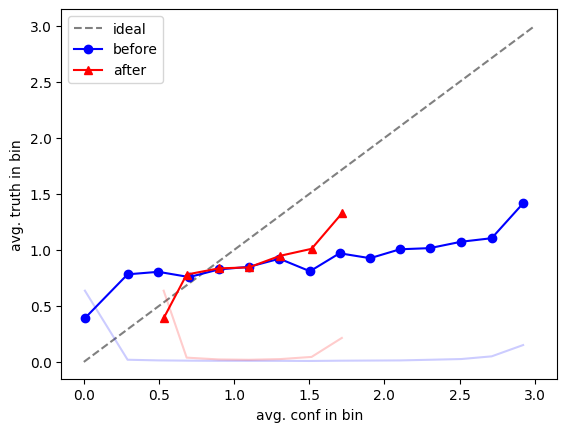

In [6]:
dev_y, dev_p = convert_samples_to_flat_format(dev_samples, key="scores")

counts = [dev_y.count(x) for x in range(max_grade+1)]
print(counts)

lr = LR()
lr.fit(np.asarray(dev_p).reshape(-1, 1), dev_y)
# print(lr.coef_, lr.intercept_)

print("DEV --")
eval_model_or_param_on_samples(
    model_type="lr",
    model_or_param=lr,
    samples=dev_samples,
    max_grade=max_grade,
    skip_query_level_ece=skip_query_level_ece
)

print("\n\nTEST --")
eval_model_or_param_on_samples(
    model_type="lr",
    model_or_param=lr,
    samples=test_samples,
    max_grade=max_grade,
    skip_query_level_ece=skip_query_level_ece
)

## isotonic regression

DEV --
	BEFORE 	 AFTER
nDCG:	0.895	0.895
MSE:	1.227	0.729
ECE_y:	0.579	0.401
ECE:	0.621	0.000


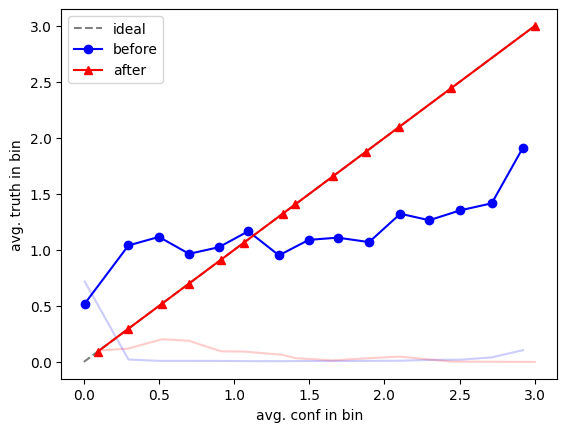



TEST --
	BEFORE 	 AFTER
nDCG:	0.856	0.848
MSE:	1.375	0.722
ECE_y:	0.704	0.423
ECE:	0.674	0.210


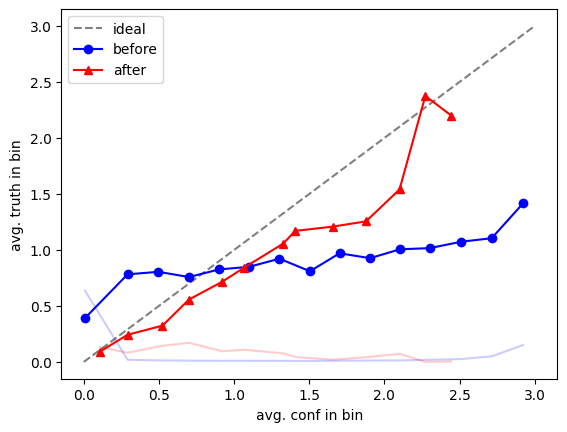

In [7]:
dev_y, dev_p = convert_samples_to_flat_format(dev_samples, key="scores")

ir = IR()
ir.fit(dev_p, dev_y)

print("DEV --")
eval_model_or_param_on_samples(
    model_type="ir",
    model_or_param=ir,
    samples=dev_samples,
    max_grade=max_grade,
    skip_query_level_ece=skip_query_level_ece
)

print("\n\nTEST --")
eval_model_or_param_on_samples(
    model_type="ir",
    model_or_param=ir,
    samples=test_samples,
    max_grade=max_grade,
    skip_query_level_ece=skip_query_level_ece
)

## temperature scaling

Epoch 0, Loss: 1.2272, Temperature: 1.0025
Epoch 1000, Loss: 0.9658, Temperature: 2.5749
Epoch 2000, Loss: 0.8784, Temperature: 3.5043
Epoch 3000, Loss: 0.8337, Temperature: 4.1706
Epoch 4000, Loss: 0.8091, Temperature: 4.6645
Epoch 5000, Loss: 0.7949, Temperature: 5.0400
Epoch 6000, Loss: 0.7863, Temperature: 5.3320
Epoch 7000, Loss: 0.7810, Temperature: 5.5636
Epoch 8000, Loss: 0.7775, Temperature: 5.7502
Epoch 9000, Loss: 0.7751, Temperature: 5.9026
DEV --
	BEFORE 	 AFTER
nDCG:	0.895	0.895
MSE:	1.227	0.774
ECE_y:	0.579	0.438
ECE:	0.621	0.114


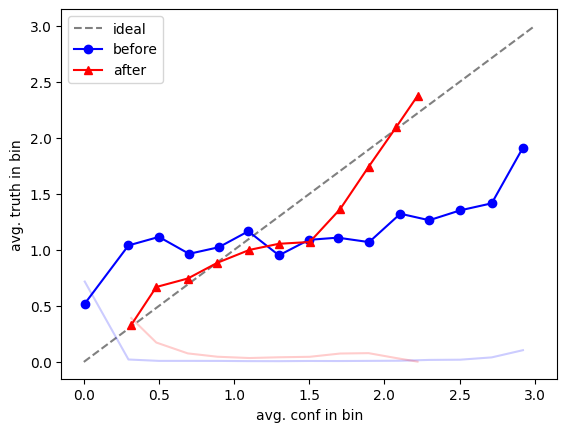



TEST --
	BEFORE 	 AFTER
nDCG:	0.856	0.856
MSE:	1.375	0.785
ECE_y:	0.704	0.469
ECE:	0.674	0.270


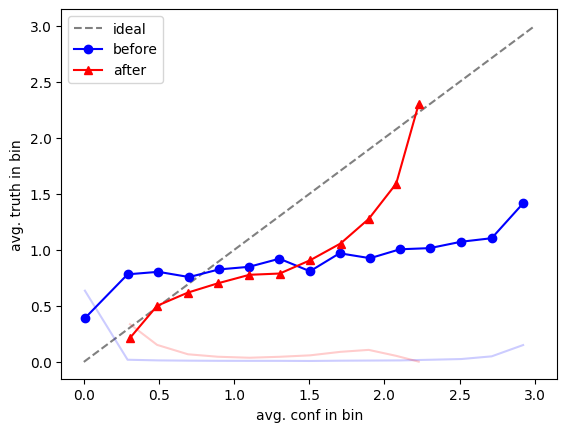

In [8]:
dev_y, dev_l = convert_samples_to_flat_format(dev_samples, key="logits")

ts = Temperature_Scaling(
    training_logits=dev_l,
    training_y=dev_y,
    max_grade=max_grade,
    learning_rate=1e-2,
    num_epochs=10000,
    init_t=1.0,
    is_regression=not binarize_labels
)

optimal_t = ts.train_temperature_scaling()

print("DEV --")
eval_model_or_param_on_samples(
    model_type="ts",
    model_or_param=optimal_t,
    samples=dev_samples,
    max_grade=max_grade,
    skip_query_level_ece=skip_query_level_ece
)

print("\n\nTEST --")
eval_model_or_param_on_samples(
    model_type="ts",
    model_or_param=optimal_t,
    samples=test_samples,
    max_grade=max_grade,
    skip_query_level_ece=skip_query_level_ece
)